# Bank Marketing Model Comparison Notebook
This notebook compares **Decision Tree** and **Random Forest** classifiers on the UCI Bank Marketing dataset,
evaluating their predictive performance, interpretability, and computational efficiency.

Cell 1: Import Libraries and Setup

In [ ]:
"""
Cell 1: Import Libraries and Setup
Purpose: Load all required libraries and set up visualization style
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import warnings

from joblib import dump
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, brier_score_loss,
    roc_curve, roc_auc_score, precision_recall_curve,
    average_precision_score, auc
)
from sklearn.calibration import calibration_curve
from scipy.sparse import vstack
from scipy.stats import ttest_rel

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")

All libraries imported successfully!
Pandas version: 2.3.2
Scikit-learn version: 1.6.1


Cell 2: Load Data and Split into Train/Val/Test

In [32]:
"""
Cell 2: Load Data and Split into Train/Val/Test
Purpose: Load Bank Marketing dataset and split into 60/20/20
"""

print("="*80)
print("STEP 1: LOADING AND SPLITTING DATA")
print("="*80)

# Load dataset
df = pd.read_csv("bank-full.csv", sep=";")
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Prepare features and target
X = df.drop("y", axis=1)
y = df["y"].map({"no": 0, "yes": 1})  # Binary classification

# Check class distribution
print(f"\nClass distribution:")
print(y.value_counts())
print(f"Positive class ratio: {y.mean():.2%}")

# Split: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\n Data split completed:")
print(f"   Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"   Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
print(f"   Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

# Display first few rows
print("\n" + "="*80)
print("Sample Data (first 3 rows):")
print("="*80)
display(df.head(3))

STEP 1: LOADING AND SPLITTING DATA
Dataset loaded: 45211 rows, 17 columns

Class distribution:
y
0    39922
1     5289
Name: count, dtype: int64
Positive class ratio: 11.70%

 Data split completed:
   Training set:   27126 samples (60.0%)
   Validation set: 9042 samples (20.0%)
   Test set:       9043 samples (20.0%)

Sample Data (first 3 rows):


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


Cell 3: Prepare Data Without Duration Feature


In [33]:
"""
Cell 3: Prepare Data Without Duration Feature
Purpose: Create alternative datasets excluding 'duration' for deployment scenario
"""

print("="*80)
print("STEP 2: PREPARING DATA WITHOUT DURATION FEATURE")
print("="*80)

# Identify features without duration
features_without_duration = [col for col in X.columns if col != 'duration']
print(f"Original features: {len(X.columns)}")
print(f"Features without duration: {len(features_without_duration)}")
print(f"\n Removed feature: 'duration'")
print("Reason: Duration is only available AFTER call ends, unsuitable for prediction")

# Create datasets without duration
X_train_no_dur = X_train[features_without_duration]
X_val_no_dur = X_val[features_without_duration]
X_test_no_dur = X_test[features_without_duration]

print(f"\n Alternative datasets created:")
print(f"   X_train_no_dur: {X_train_no_dur.shape}")
print(f"   X_val_no_dur:   {X_val_no_dur.shape}")
print(f"   X_test_no_dur:  {X_test_no_dur.shape}")

STEP 2: PREPARING DATA WITHOUT DURATION FEATURE
Original features: 16
Features without duration: 15

 Removed feature: 'duration'
Reason: Duration is only available AFTER call ends, unsuitable for prediction

 Alternative datasets created:
   X_train_no_dur: (27126, 15)
   X_val_no_dur:   (9042, 15)
   X_test_no_dur:  (9043, 15)


Cell 4: One-Hot Encoding for Categorical Features


In [34]:
"""
Cell 4: One-Hot Encoding for Categorical Features
Purpose: Encode categorical variables to numerical format
"""

print("="*80)
print("STEP 3: ONE-HOT ENCODING")
print("="*80)

# Identify categorical features
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# --- WITH Duration ---
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)

preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_val_enc = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

print(f"\n WITH Duration - Encoding completed:")
print(f"   Original shape: {X_train.shape}")
print(f"   Encoded shape:  {X_train_enc.shape}")
print(f"   Total features after encoding: {X_train_enc.shape[1]}")

# --- WITHOUT Duration ---
preprocessor_no_dur = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)

preprocessor_no_dur.fit(X_train_no_dur)
X_train_no_dur_enc = preprocessor_no_dur.transform(X_train_no_dur)
X_val_no_dur_enc = preprocessor_no_dur.transform(X_val_no_dur)
X_test_no_dur_enc = preprocessor_no_dur.transform(X_test_no_dur)

print(f"\n WITHOUT Duration - Encoding completed:")
print(f"   Original shape: {X_train_no_dur.shape}")
print(f"   Encoded shape:  {X_train_no_dur_enc.shape}")
print(f"   Total features after encoding: {X_train_no_dur_enc.shape[1]}")

STEP 3: ONE-HOT ENCODING
Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

 WITH Duration - Encoding completed:
   Original shape: (27126, 16)
   Encoded shape:  (27126, 51)
   Total features after encoding: 51

 WITHOUT Duration - Encoding completed:
   Original shape: (27126, 15)
   Encoded shape:  (27126, 50)
   Total features after encoding: 50


Cell 5: Decision Tree Hyperparameter Tuning


STEP 4: DECISION TREE HYPERPARAMETER TUNING
Parameter grid:
  max_depth: [5, 10, 15, 20, 25, 30, None]
  min_samples_split: [2, 5, 10, 15, 20, 25, 30]
  Total combinations: 49

Starting grid search...

 Best Decision Tree Parameters:
   {'max_depth': 10, 'min_samples_split': 10}
   Validation F1 Score: 0.5097


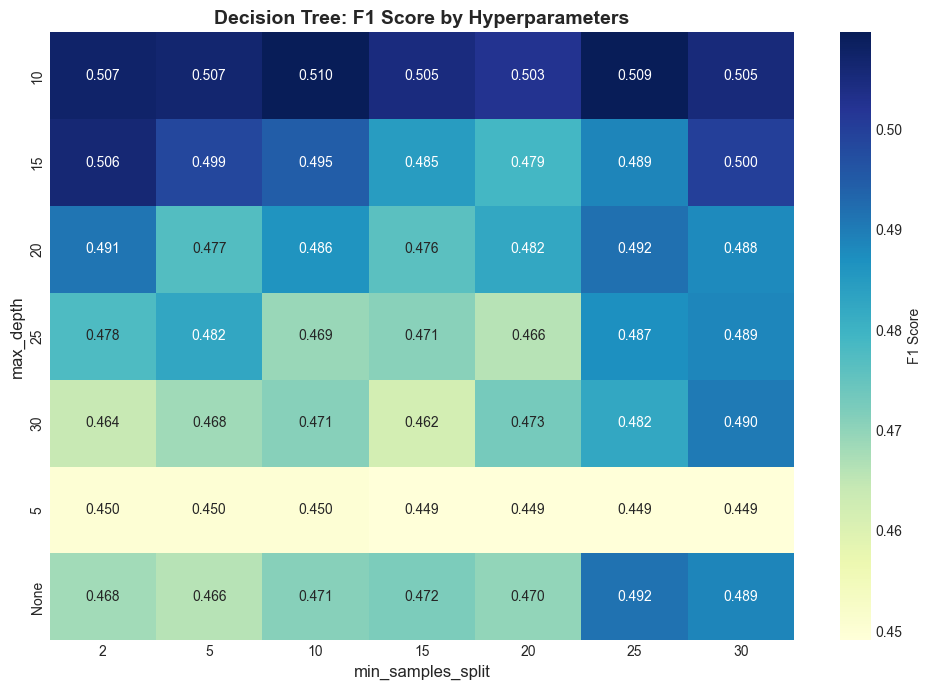

In [35]:
"""
Cell 5: Decision Tree Hyperparameter Tuning
Purpose: Grid search for optimal max_depth and min_samples_split
"""

print("="*80)
print("STEP 4: DECISION TREE HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grid
dt_params = {
    "max_depth": [5, 10, 15, 20, 25, 30, None],
    "min_samples_split": [2, 5, 10, 15, 20, 25, 30]
}

print(f"Parameter grid:")
print(f"  max_depth: {dt_params['max_depth']}")
print(f"  min_samples_split: {dt_params['min_samples_split']}")
print(f"  Total combinations: {len(dt_params['max_depth']) * len(dt_params['min_samples_split'])}")

# Grid search
results_dt = []
best_dt_score, best_dt_params = 0, None

print("\nStarting grid search...")
for depth in dt_params["max_depth"]:
    for min_split in dt_params["min_samples_split"]:
        dt = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_split=min_split,
            random_state=42
        )
        dt.fit(X_train_enc, y_train)
        y_val_pred = dt.predict(X_val_enc)
        f1 = f1_score(y_val, y_val_pred)

        results_dt.append({
            "max_depth": str(depth),
            "min_samples_split": min_split,
            "f1": f1
        })

        if f1 > best_dt_score:
            best_dt_score = f1
            best_dt_params = {"max_depth": depth, "min_samples_split": min_split}

print(f"\n Best Decision Tree Parameters:")
print(f"   {best_dt_params}")
print(f"   Validation F1 Score: {best_dt_score:.4f}")

# Visualize results as heatmap
df_dt_heat = pd.DataFrame(results_dt)
heatmap_dt = df_dt_heat.pivot(index="max_depth", columns="min_samples_split", values="f1")

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_dt, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'F1 Score'})
plt.title("Decision Tree: F1 Score by Hyperparameters", fontsize=14, fontweight='bold')
plt.ylabel("max_depth", fontsize=12)
plt.xlabel("min_samples_split", fontsize=12)
plt.tight_layout()
plt.show()

Cell 6: Random Forest Hyperparameter Tuning


STEP 5: RANDOM FOREST HYPERPARAMETER TUNING
Parameter grid:
  n_estimators: [10, 50, 100, 200, 250, 300]
  max_depth: [5, 10, 15, 20, 25, None]
  Total combinations: 36

Starting grid search (this may take a few minutes)...
  Completed n_estimators=10
  Completed n_estimators=50
  Completed n_estimators=100
  Completed n_estimators=200
  Completed n_estimators=250
  Completed n_estimators=300

 Best Random Forest Parameters:
   {'n_estimators': 200, 'max_depth': None}
   Validation F1 Score: 0.5033


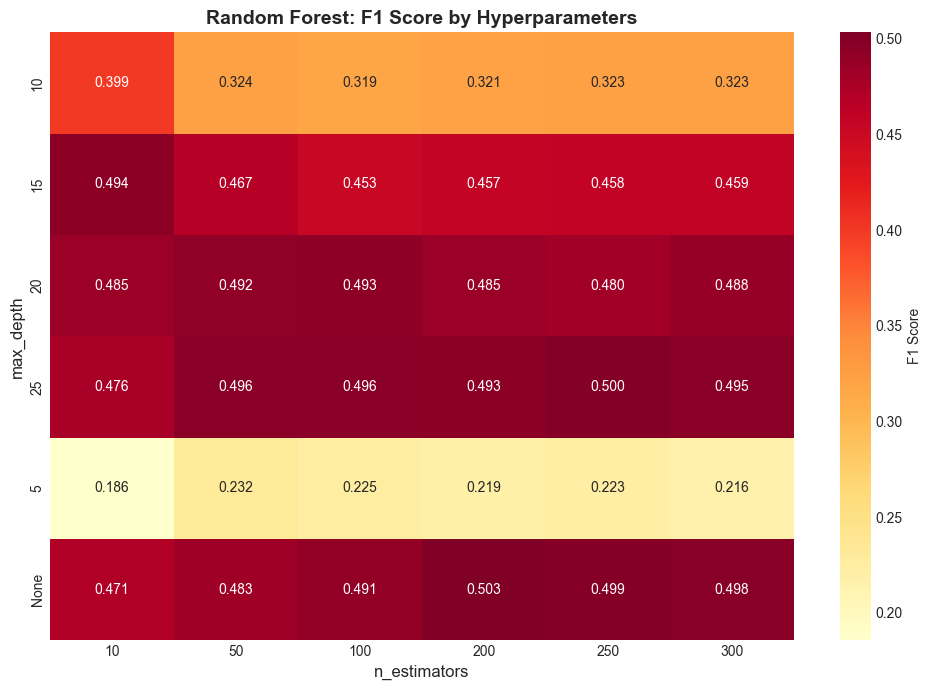

In [36]:
"""
Cell 6: Random Forest Hyperparameter Tuning
Purpose: Grid search for optimal n_estimators and max_depth
"""

print("="*80)
print("STEP 5: RANDOM FOREST HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grid
rf_params = {
    "n_estimators": [10, 50, 100, 200, 250, 300],
    "max_depth": [5, 10, 15, 20, 25, None]
}

print(f"Parameter grid:")
print(f"  n_estimators: {rf_params['n_estimators']}")
print(f"  max_depth: {rf_params['max_depth']}")
print(f"  Total combinations: {len(rf_params['n_estimators']) * len(rf_params['max_depth'])}")

# Grid search
results_rf = []
best_rf_score, best_rf_params = 0, None

print("\nStarting grid search (this may take a few minutes)...")
for n in rf_params["n_estimators"]:
    for depth in rf_params["max_depth"]:
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=depth,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_enc, y_train)
        y_val_pred = rf.predict(X_val_enc)
        f1 = f1_score(y_val, y_val_pred)

        results_rf.append({
            "n_estimators": n,
            "max_depth": str(depth),
            "f1": f1
        })

        if f1 > best_rf_score:
            best_rf_score = f1
            best_rf_params = {"n_estimators": n, "max_depth": depth}

    print(f"  Completed n_estimators={n}")

print(f"\n Best Random Forest Parameters:")
print(f"   {best_rf_params}")
print(f"   Validation F1 Score: {best_rf_score:.4f}")

# Visualize results as heatmap
df_rf_heat = pd.DataFrame(results_rf)
heatmap_rf = df_rf_heat.pivot(index="max_depth", columns="n_estimators", values="f1")

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_rf, annot=True, fmt=".3f", cmap="YlOrRd", cbar_kws={'label': 'F1 Score'})
plt.title("Random Forest: F1 Score by Hyperparameters", fontsize=14, fontweight='bold')
plt.ylabel("max_depth", fontsize=12)
plt.xlabel("n_estimators", fontsize=12)
plt.tight_layout()
plt.show()

Cell 7: Train Final Models with Best Parameters


In [37]:
"""
Cell 7: Train Final Models with Best Parameters
Purpose: Retrain models on combined train+val set for both scenarios
"""

print("="*80)
print("STEP 6: TRAINING FINAL MODELS")
print("="*80)

# Combine training and validation sets
X_train_val_enc = vstack([X_train_enc, X_val_enc])
y_train_val = np.concatenate([y_train, y_val])

X_train_val_no_dur_enc = vstack([X_train_no_dur_enc, X_val_no_dur_enc])

print(f"Combined training set size: {X_train_val_enc.shape[0]} samples")

# --- WITH Duration ---
print("\n--- Training WITH Duration ---")
best_dt = DecisionTreeClassifier(**best_dt_params, random_state=42)
best_dt.fit(X_train_val_enc, y_train_val)
print(f" Decision Tree trained (depth={best_dt.tree_.max_depth}, nodes={best_dt.tree_.node_count})")

best_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_val_enc, y_train_val)
n_trees = len(best_rf.estimators_)
avg_depth = np.mean([tree.tree_.max_depth for tree in best_rf.estimators_])
print(f" Random Forest trained ({n_trees} trees, avg depth={avg_depth:.1f})")

# --- WITHOUT Duration ---
print("\n--- Training WITHOUT Duration ---")
best_dt_no_dur = DecisionTreeClassifier(**best_dt_params, random_state=42)
best_dt_no_dur.fit(X_train_val_no_dur_enc, y_train_val)
print(f" Decision Tree (no dur) trained (depth={best_dt_no_dur.tree_.max_depth}, nodes={best_dt_no_dur.tree_.node_count})")

best_rf_no_dur = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
best_rf_no_dur.fit(X_train_val_no_dur_enc, y_train_val)
print(f" Random Forest (no dur) trained ({len(best_rf_no_dur.estimators_)} trees)")

# Store models in dictionaries
models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf
}

models_no_dur = {
    "Decision Tree (no dur)": best_dt_no_dur,
    "Random Forest (no dur)": best_rf_no_dur
}

print("\n All models trained successfully!")

STEP 6: TRAINING FINAL MODELS
Combined training set size: 36168 samples

--- Training WITH Duration ---
 Decision Tree trained (depth=10, nodes=683)
 Random Forest trained (200 trees, avg depth=36.6)

--- Training WITHOUT Duration ---
 Decision Tree (no dur) trained (depth=10, nodes=455)
 Random Forest (no dur) trained (200 trees)

 All models trained successfully!


Cell 8: Performance Evaluation - WITH Duration


In [38]:
"""
Cell 8: Performance Evaluation - WITH Duration
Purpose: Evaluate models on test set with all features including duration
"""

print("="*80)
print("STEP 7: PERFORMANCE EVALUATION (WITH DURATION)")
print("="*80)

results_with = []

for name, model in models.items():
    y_pred = model.predict(X_test_enc)
    y_proba = model.predict_proba(X_test_enc)[:, 1]

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    }
    results_with.append(metrics)

    print(f"\n{'='*50}")
    print(f"{name}")
    print(f"{'='*50}")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1 Score:  {metrics['F1']:.4f}")
    print(f"  AUC:       {metrics['AUC']:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["no", "yes"]))

# Create summary DataFrame
df_results_with = pd.DataFrame(results_with)
print("\n" + "="*80)
print("SUMMARY TABLE - WITH DURATION")
print("="*80)
display(df_results_with.round(4))

STEP 7: PERFORMANCE EVALUATION (WITH DURATION)

Decision Tree
  Accuracy:  0.9003
  Precision: 0.6089
  Recall:    0.4121
  F1 Score:  0.4915
  AUC:       0.8515

Classification Report:
              precision    recall  f1-score   support

          no       0.93      0.96      0.94      7985
         yes       0.61      0.41      0.49      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.69      0.72      9043
weighted avg       0.89      0.90      0.89      9043


Random Forest
  Accuracy:  0.9072
  Precision: 0.6730
  Recall:    0.4026
  F1 Score:  0.5038
  AUC:       0.9291

Classification Report:
              precision    recall  f1-score   support

          no       0.92      0.97      0.95      7985
         yes       0.67      0.40      0.50      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.69      0.73      9043
weighted avg       0.90      0.91      0.90      9043


SUMMARY TABLE - WITH

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree,0.9003,0.6089,0.4121,0.4915,0.8515
1,Random Forest,0.9072,0.6730,0.4026,0.5038,0.9291


Cell 9: Performance Evaluation - WITHOUT Duration


In [39]:
"""
Cell 9: Performance Evaluation - WITHOUT Duration
Purpose: Evaluate deployment-ready models excluding duration feature
"""

print("="*80)
print("STEP 8: PERFORMANCE EVALUATION (WITHOUT DURATION)")
print("="*80)

results_without = []

for name, model in models_no_dur.items():
    y_pred = model.predict(X_test_no_dur_enc)
    y_proba = model.predict_proba(X_test_no_dur_enc)[:, 1]

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    }
    results_without.append(metrics)

    print(f"\n{'='*50}")
    print(f"{name}")
    print(f"{'='*50}")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1 Score:  {metrics['F1']:.4f}")
    print(f"  AUC:       {metrics['AUC']:.4f}")

# Create summary DataFrame
df_results_without = pd.DataFrame(results_without)
print("\n" + "="*80)
print("SUMMARY TABLE - WITHOUT DURATION")
print("="*80)
display(df_results_without.round(4))

STEP 8: PERFORMANCE EVALUATION (WITHOUT DURATION)

Decision Tree (no dur)
  Accuracy:  0.8911
  Precision: 0.5929
  Recall:    0.2202
  F1 Score:  0.3212
  AUC:       0.7214

Random Forest (no dur)
  Accuracy:  0.8955
  Precision: 0.6402
  Recall:    0.2439
  F1 Score:  0.3532
  AUC:       0.7932

SUMMARY TABLE - WITHOUT DURATION


,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree (no dur),0.8911,0.5929,0.2202,0.3212,0.7214
1,Random Forest (no dur),0.8955,0.6402,0.2439,0.3532,0.7932


Cell 10: Generate Performance Comparison Table (Table 3 for Paper)


In [40]:
"""
Cell 10: Generate Performance Comparison Table (Table 3 for Paper)
Purpose: Create LaTeX table comparing WITH vs WITHOUT duration scenarios
"""

print("="*80)
print("PERFORMANCE COMPARISON: WITH VS WITHOUT DURATION")
print("="*80)

# Extract data
dt_with = df_results_with[df_results_with['Model'] == 'Decision Tree'].iloc[0]
rf_with = df_results_with[df_results_with['Model'] == 'Random Forest'].iloc[0]
dt_without = df_results_without[df_results_without['Model'] == 'Decision Tree (no dur)'].iloc[0]
rf_without = df_results_without[df_results_without['Model'] == 'Random Forest (no dur)'].iloc[0]

# Calculate drops
def calc_drop(with_val, without_val):
    return (with_val - without_val) / with_val * 100

print("\n--- Decision Tree ---")
print(f"Accuracy:  {dt_with['Accuracy']:.3f} → {dt_without['Accuracy']:.3f} "
      f"({calc_drop(dt_with['Accuracy'], dt_without['Accuracy']):+.1f}%)")
print(f"F1 Score:  {dt_with['F1']:.3f} → {dt_without['F1']:.3f} "
      f"({calc_drop(dt_with['F1'], dt_without['F1']):+.1f}%)")
print(f"AUC:       {dt_with['AUC']:.3f} → {dt_without['AUC']:.3f} "
      f"({calc_drop(dt_with['AUC'], dt_without['AUC']):+.1f}%)")

print("\n--- Random Forest ---")
print(f"Accuracy:  {rf_with['Accuracy']:.3f} → {rf_without['Accuracy']:.3f} "
      f"({calc_drop(rf_with['Accuracy'], rf_without['Accuracy']):+.1f}%)")
print(f"F1 Score:  {rf_with['F1']:.3f} → {rf_without['F1']:.3f} "
      f"({calc_drop(rf_with['F1'], rf_without['F1']):+.1f}%)")
print(f"AUC:       {rf_with['AUC']:.3f} → {rf_without['AUC']:.3f} "
      f"({calc_drop(rf_with['AUC'], rf_without['AUC']):+.1f}%)")


PERFORMANCE COMPARISON: WITH VS WITHOUT DURATION

--- Decision Tree ---
Accuracy:  0.900 → 0.891 (+1.0%)
F1 Score:  0.492 → 0.321 (+34.7%)
AUC:       0.852 → 0.721 (+15.3%)

--- Random Forest ---
Accuracy:  0.907 → 0.895 (+1.3%)
F1 Score:  0.504 → 0.353 (+29.9%)
AUC:       0.929 → 0.793 (+14.6%)


Cell 11: Confusion Matrix Visualization


CONFUSION MATRICES (WITH DURATION)

Decision Tree:
  True Positives:   436  |  False Positives:  280
  False Negatives:  622  |  True Negatives:  7705
  Sensitivity (Recall): 0.412
  Specificity:          0.965

Random Forest:
  True Positives:   426  |  False Positives:  207
  False Negatives:  632  |  True Negatives:  7778
  Sensitivity (Recall): 0.403
  Specificity:          0.974


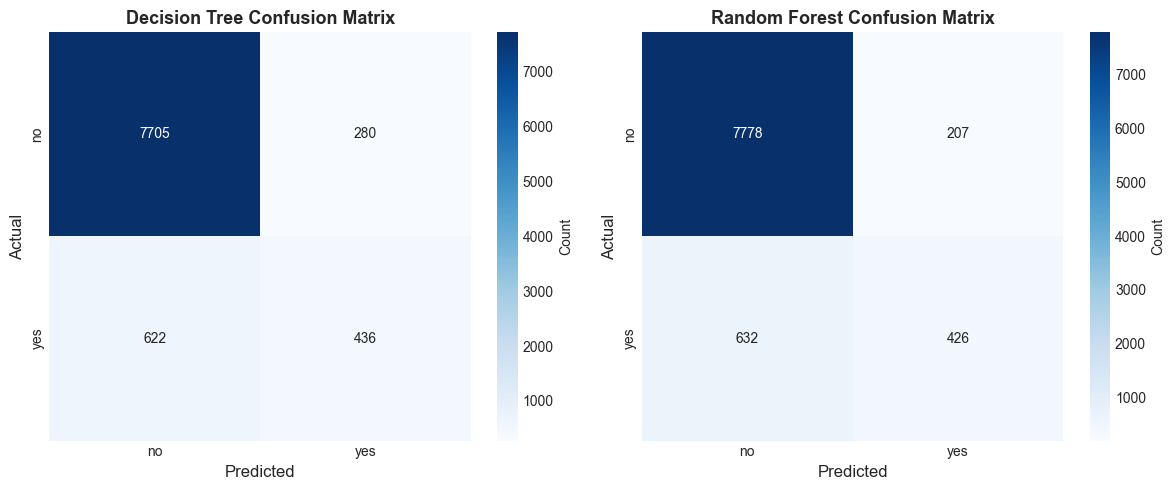

In [41]:
"""
Cell 11: Confusion Matrix Visualization
Purpose: Visualize prediction errors for both models (WITH duration)
"""

print("="*80)
print("CONFUSION MATRICES (WITH DURATION)")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_enc)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=["no", "yes"], yticklabels=["no", "yes"],
                cbar_kws={'label': 'Count'})
    axes[idx].set_xlabel("Predicted", fontsize=12)
    axes[idx].set_ylabel("Actual", fontsize=12)
    axes[idx].set_title(f"{name} Confusion Matrix", fontsize=13, fontweight='bold')

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"\n{name}:")
    print(f"  True Positives:  {tp:4d}  |  False Positives: {fp:4d}")
    print(f"  False Negatives: {fn:4d}  |  True Negatives:  {tn:4d}")
    print(f"  Sensitivity (Recall): {sensitivity:.3f}")
    print(f"  Specificity:          {specificity:.3f}")

plt.tight_layout()
plt.show()

Cell 12: Learning Curves


LEARNING CURVES ANALYSIS

Decision Tree:
  Training size:  2893 | Train score: 0.9487 | Val score: 0.8881
  Training size:  9403 | Train score: 0.9336 | Val score: 0.8915
  Training size: 15913 | Train score: 0.9320 | Val score: 0.8956
  Training size: 22423 | Train score: 0.9291 | Val score: 0.8976
  Training size: 28934 | Train score: 0.9263 | Val score: 0.8982

Random Forest:
  Training size:  2893 | Train score: 1.0000 | Val score: 0.9004
  Training size:  9403 | Train score: 1.0000 | Val score: 0.9033
  Training size: 15913 | Train score: 1.0000 | Val score: 0.9026
  Training size: 22423 | Train score: 1.0000 | Val score: 0.9039
  Training size: 28934 | Train score: 1.0000 | Val score: 0.9050


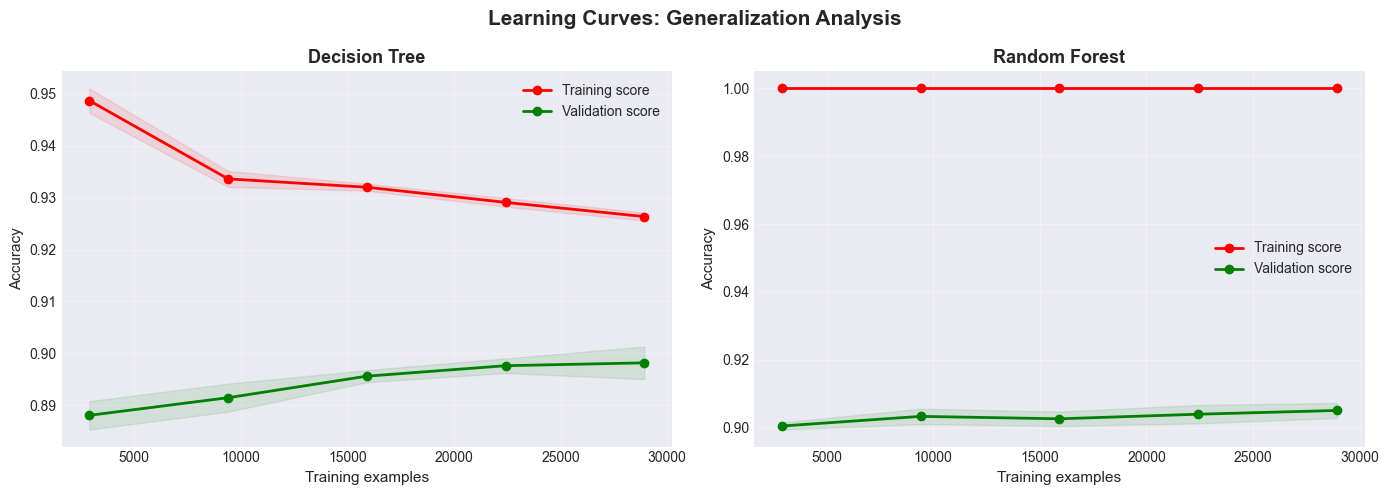

In [42]:
"""
Cell 12: Learning Curves
Purpose: Analyze model generalization across different training sizes
"""

print("="*80)
print("LEARNING CURVES ANALYSIS")
print("="*80)

def plot_learning_curve(model, X, y, title="Learning Curve", cv=5,
                        scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), ax=None):
    """Plot learning curve for a given model"""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring,
        train_sizes=train_sizes, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Print values
    print(f"\n{title}:")
    for i, size in enumerate(train_sizes):
        print(f"  Training size: {size:5.0f} | "
              f"Train score: {train_scores_mean[i]:.4f} | "
              f"Val score: {val_scores_mean[i]:.4f}")

    if ax is None:
        ax = plt.gca()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score", linewidth=2)
    ax.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score", linewidth=2)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel("Training examples", fontsize=11)
    ax.set_ylabel("Accuracy", fontsize=11)
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Learning Curves: Generalization Analysis", fontsize=15, fontweight='bold')

# Decision Tree
best_dt_temp = DecisionTreeClassifier(**best_dt_params, random_state=42)
plot_learning_curve(best_dt_temp, X_train_val_enc, y_train_val,
                    title="Decision Tree", ax=axes[0])

# Random Forest
best_rf_temp = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
plot_learning_curve(best_rf_temp, X_train_val_enc, y_train_val,
                    title="Random Forest", ax=axes[1])

plt.tight_layout()
plt.show()

Cell 13: Cross-Validation Analysis


5-FOLD CROSS-VALIDATION ANALYSIS

Computing Decision Tree CV scores...
Decision Tree:
  F1 Scores by fold: ['0.477', '0.473', '0.476', '0.495', '0.495']
  Mean F1:  0.483
  Std Dev:  0.010
  Range:    0.023

Computing Random Forest CV scores...
Random Forest:
  F1 Scores by fold: ['0.484', '0.483', '0.474', '0.493', '0.511']
  Mean F1:  0.489
  Std Dev:  0.013
  Range:    0.037


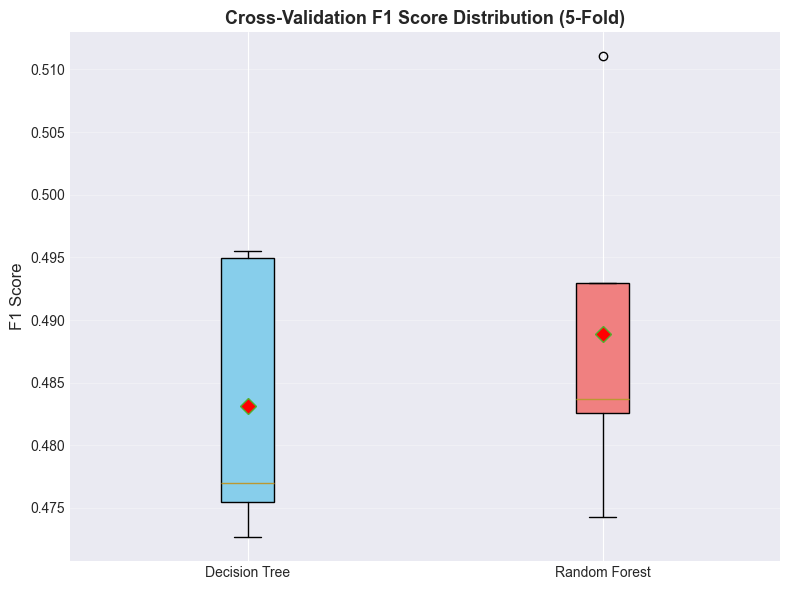


 Cross-validation completed!


In [ ]:
"""
Cell 13: Cross-Validation Analysis
Purpose: Evaluate model stability across different data splits
"""

print("="*80)
print("5-FOLD CROSS-VALIDATION ANALYSIS")
print("="*80)

# Decision Tree CV
print("\nComputing Decision Tree CV scores...")
dt_cv_scores = cross_val_score(
    DecisionTreeClassifier(**best_dt_params, random_state=42),
    X_train_val_enc, y_train_val,
    cv=5, scoring='f1', n_jobs=-1
)

print(f"Decision Tree:")
print(f"  F1 Scores by fold: {[f'{score:.3f}' for score in dt_cv_scores]}")
print(f"  Mean F1:  {dt_cv_scores.mean():.3f}")
print(f"  Std Dev:  {dt_cv_scores.std():.3f}")
print(f"  Range:    {dt_cv_scores.max() - dt_cv_scores.min():.3f}")

# Random Forest CV
print("\nComputing Random Forest CV scores...")
rf_cv_scores = cross_val_score(
    RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1),
    X_train_val_enc, y_train_val,
    cv=5, scoring='f1', n_jobs=-1
)

print(f"Random Forest:")
print(f"  F1 Scores by fold: {[f'{score:.3f}' for score in rf_cv_scores]}")
print(f"  Mean F1:  {rf_cv_scores.mean():.3f}")
print(f"  Std Dev:  {rf_cv_scores.std():.3f}")
print(f"  Range:    {rf_cv_scores.max() - rf_cv_scores.min():.3f}")

t_stat, p_value = ttest_rel(rf_cv_scores, dt_cv_scores)
print(f"Paired t-test: t={t_stat:.3f}, p={p_value:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot([dt_cv_scores, rf_cv_scores],
                 tick_labels=['Decision Tree', 'Random Forest'],
                 patch_artist=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Color the boxes
colors = ['skyblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel("F1 Score", fontsize=12)
ax.set_title("Cross-Validation F1 Score Distribution (5-Fold)", fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Cross-validation completed!")

Cell 14: Feature Importance Analysis - WITH Duration


FEATURE IMPORTANCE ANALYSIS (WITH DURATION)
Total features after encoding: 51

--- Top 10 Features (Decision Tree) ---
 1. duration                                : 0.4192 (41.92%)
 2. poutcome_success                        : 0.1996 (19.96%)
 3. pdays                                   : 0.0517 (5.17%)
 4. age                                     : 0.0514 (5.14%)
 5. day                                     : 0.0426 (4.26%)
 6. housing_yes                             : 0.0327 (3.27%)
 7. balance                                 : 0.0312 (3.12%)
 8. month_mar                               : 0.0302 (3.02%)
 9. month_apr                               : 0.0171 (1.71%)
10. contact_unknown                         : 0.0138 (1.38%)

--- Top 10 Features (Random Forest) ---
 1. duration                                : 0.2670 (26.70%)
 2. balance                                 : 0.0935 (9.35%)
 3. age                                     : 0.0908 (9.08%)
 4. day                                     

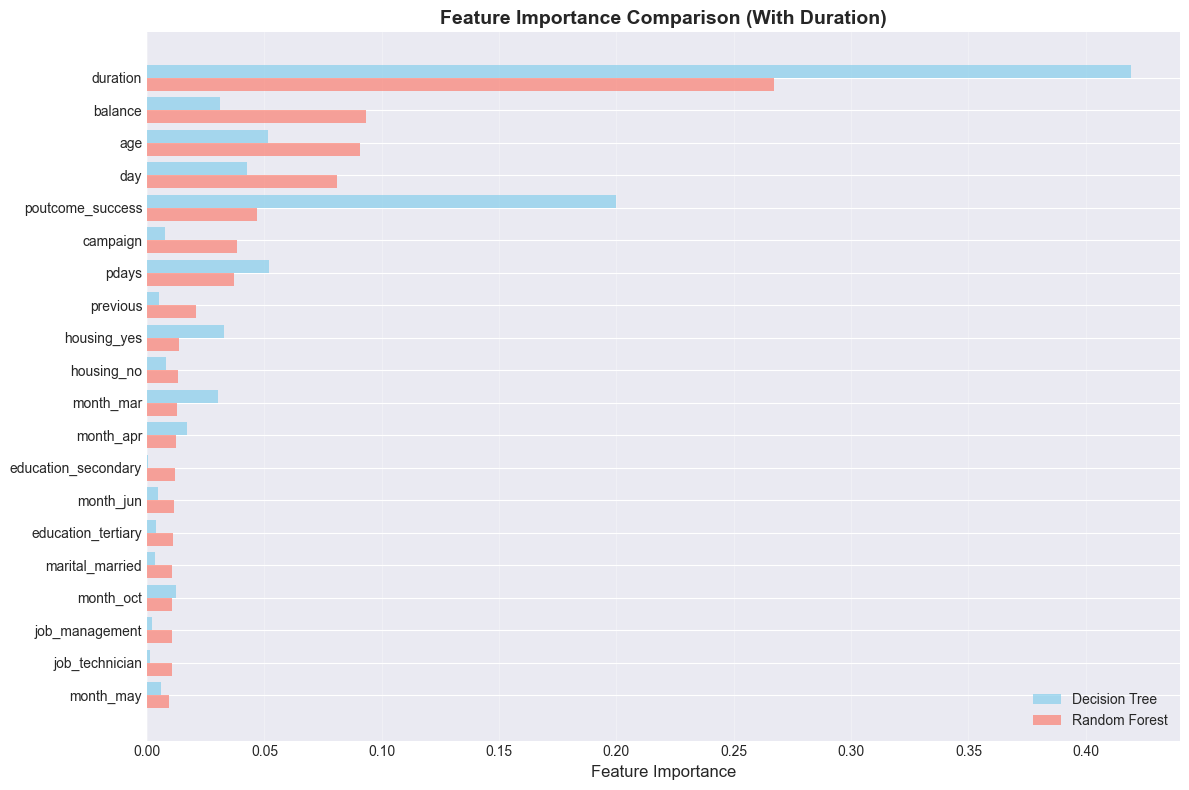

In [44]:
"""
Cell 14: Feature Importance Analysis - WITH Duration
Purpose: Identify key predictors when duration is available
"""

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS (WITH DURATION)")
print("="*80)

# Get feature names after one-hot encoding
onehot_columns = preprocessor.named_transformers_["onehot"].get_feature_names_out(categorical_features)
numeric_features = [col for col in X_train.columns if col not in categorical_features]
feature_names = list(onehot_columns) + numeric_features

print(f"Total features after encoding: {len(feature_names)}")

# Calculate feature importance
dt_importance = pd.Series(best_dt.feature_importances_,
                         index=feature_names).sort_values(ascending=False)
rf_importance = pd.Series(best_rf.feature_importances_,
                         index=feature_names).sort_values(ascending=False)

# Print top features
print("\n--- Top 10 Features (Decision Tree) ---")
for i, (feat, imp) in enumerate(dt_importance.head(10).items(), 1):
    print(f"{i:2d}. {feat:40s}: {imp:.4f} ({imp*100:.2f}%)")

print("\n--- Top 10 Features (Random Forest) ---")
for i, (feat, imp) in enumerate(rf_importance.head(10).items(), 1):
    print(f"{i:2d}. {feat:40s}: {imp:.4f} ({imp*100:.2f}%)")

# Visualize top 20
top_n = 20
rf_top = rf_importance.head(top_n)
dt_values = dt_importance.reindex(rf_top.index).fillna(0)

y_pos = np.arange(len(rf_top))
height = 0.4

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y_pos - height/2, dt_values, height=height, alpha=0.7,
        label='Decision Tree', color='skyblue')
ax.barh(y_pos + height/2, rf_top, height=height, alpha=0.7,
        label='Random Forest', color='salmon')
ax.set_yticks(y_pos)
ax.set_yticklabels(rf_top.index)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance", fontsize=12)
ax.set_title("Feature Importance Comparison (With Duration)",
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Cell 15: Feature Importance Analysis - WITHOUT Duration


FEATURE IMPORTANCE ANALYSIS (WITHOUT DURATION)
Total features after encoding: 50

--- Top 10 Features (Decision Tree - No Duration) ---
 1. poutcome_success                        : 0.3865 (38.65%)
 2. age                                     : 0.0996 (9.96%)
 3. pdays                                   : 0.0770 (7.70%)
 4. balance                                 : 0.0619 (6.19%)
 5. day                                     : 0.0505 (5.05%)
 6. contact_unknown                         : 0.0472 (4.72%)
 7. month_jun                               : 0.0423 (4.23%)
 8. month_mar                               : 0.0407 (4.07%)
 9. month_oct                               : 0.0382 (3.82%)
10. month_sep                               : 0.0269 (2.69%)

--- Top 10 Features (Random Forest - No Duration) ---
 1. balance                                 : 0.1721 (17.21%)
 2. age                                     : 0.1491 (14.91%)
 3. day                                     : 0.1257 (12.57%)
 4. campaign

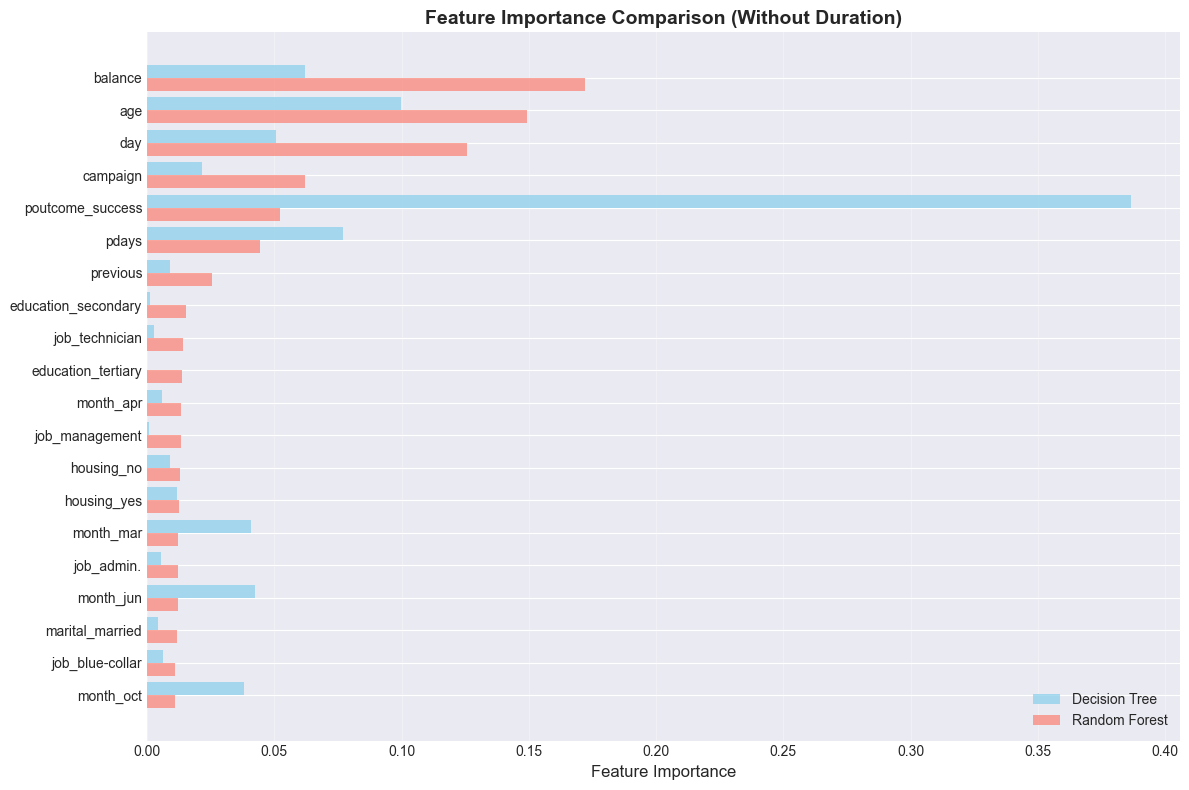

In [45]:
"""
Cell 15: Feature Importance Analysis - WITHOUT Duration
Purpose: Identify alternative predictors when duration is unavailable
"""

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS (WITHOUT DURATION)")
print("="*80)

# Get feature names (without duration)
onehot_columns_no_dur = preprocessor_no_dur.named_transformers_["onehot"].get_feature_names_out(categorical_features)
numeric_features_no_dur = [col for col in X_train_no_dur.columns if col not in categorical_features]
feature_names_no_dur = list(onehot_columns_no_dur) + numeric_features_no_dur

print(f"Total features after encoding: {len(feature_names_no_dur)}")

# Calculate feature importance
dt_importance_no_dur = pd.Series(best_dt_no_dur.feature_importances_,
                                 index=feature_names_no_dur).sort_values(ascending=False)
rf_importance_no_dur = pd.Series(best_rf_no_dur.feature_importances_,
                                 index=feature_names_no_dur).sort_values(ascending=False)

# Print top features
print("\n--- Top 10 Features (Decision Tree - No Duration) ---")
for i, (feat, imp) in enumerate(dt_importance_no_dur.head(10).items(), 1):
    print(f"{i:2d}. {feat:40s}: {imp:.4f} ({imp*100:.2f}%)")

print("\n--- Top 10 Features (Random Forest - No Duration) ---")
for i, (feat, imp) in enumerate(rf_importance_no_dur.head(10).items(), 1):
    print(f"{i:2d}. {feat:40s}: {imp:.4f} ({imp*100:.2f}%)")

# Visualize top 20
rf_top_no_dur = rf_importance_no_dur.head(top_n)
dt_values_no_dur = dt_importance_no_dur.reindex(rf_top_no_dur.index).fillna(0)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y_pos - height/2, dt_values_no_dur, height=height, alpha=0.7,
        label='Decision Tree', color='skyblue')
ax.barh(y_pos + height/2, rf_top_no_dur, height=height, alpha=0.7,
        label='Random Forest', color='salmon')
ax.set_yticks(y_pos)
ax.set_yticklabels(rf_top_no_dur.index)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance", fontsize=12)
ax.set_title("Feature Importance Comparison (Without Duration)",
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Cell 16: Side-by-Side Feature Importance Comparison


FEATURE IMPORTANCE REDISTRIBUTION ANALYSIS


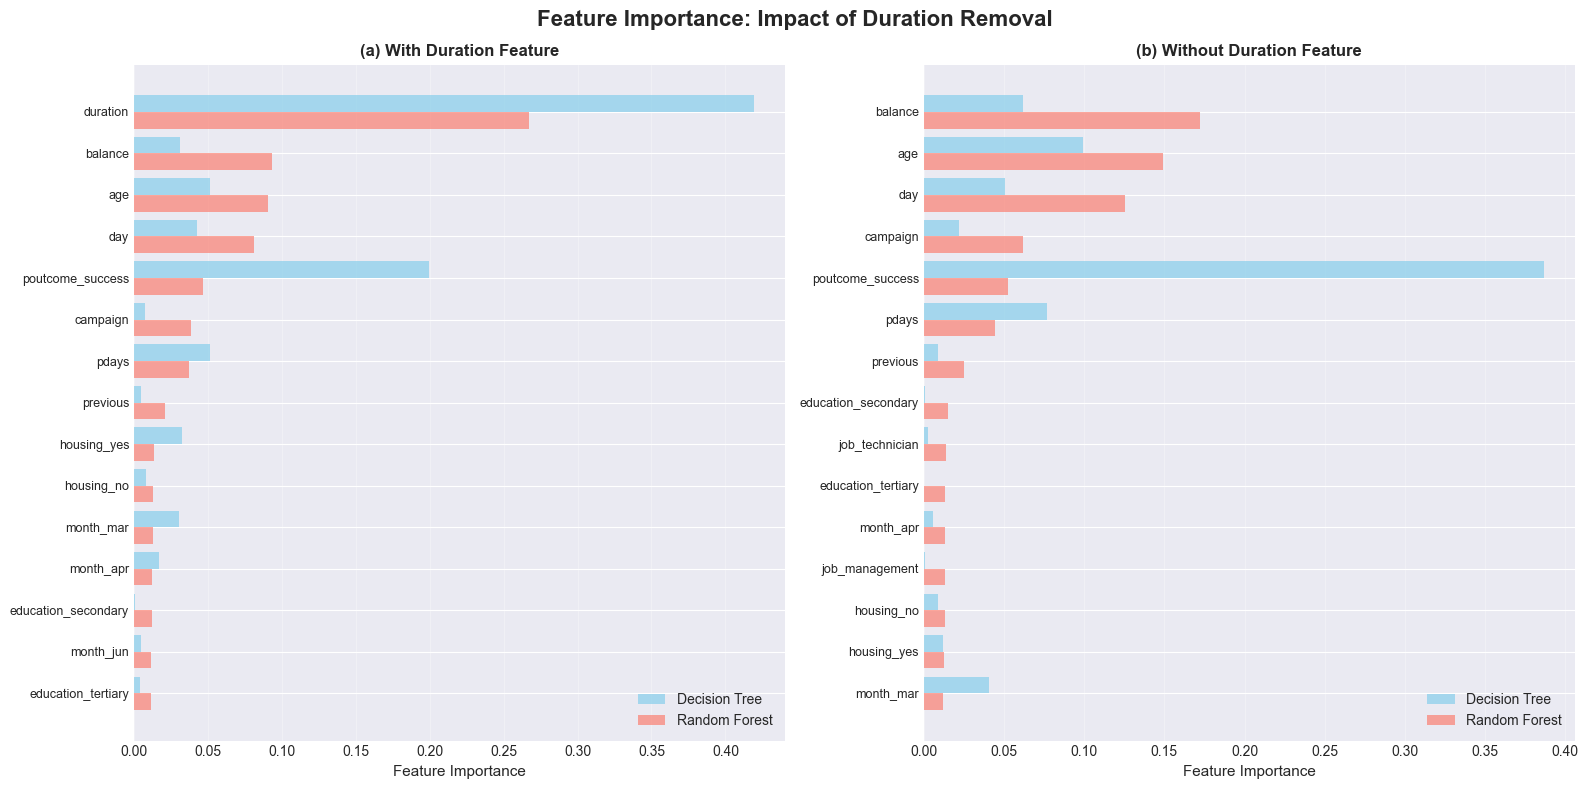


--- Importance Redistribution (Top 5 Gainers) ---
1. balance                                 :
   0.0935 → 0.1721 (+0.0787, +84.1%)
2. age                                     :
   0.0908 → 0.1491 (+0.0584, +64.3%)
3. day                                     :
   0.0809 → 0.1257 (+0.0448, +55.4%)
4. campaign                                :
   0.0383 → 0.0621 (+0.0239, +62.3%)
5. pdays                                   :
   0.0370 → 0.0444 (+0.0075, +20.2%)


In [46]:
"""
Cell 16: Side-by-Side Feature Importance Comparison
Purpose: Visualize how importance redistributes without duration
"""

print("="*80)
print("FEATURE IMPORTANCE REDISTRIBUTION ANALYSIS")
print("="*80)

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Feature Importance: Impact of Duration Removal",
             fontsize=16, fontweight='bold')

# Left: WITH Duration
rf_top_with = rf_importance.head(15)
dt_values_with = dt_importance.reindex(rf_top_with.index).fillna(0)
y_pos = np.arange(len(rf_top_with))

axes[0].barh(y_pos - height/2, dt_values_with, height=height, alpha=0.7,
             label='Decision Tree', color='skyblue')
axes[0].barh(y_pos + height/2, rf_top_with, height=height, alpha=0.7,
             label='Random Forest', color='salmon')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(rf_top_with.index, fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel("Feature Importance", fontsize=11)
axes[0].set_title("(a) With Duration Feature", fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(axis='x', alpha=0.3)

# Right: WITHOUT Duration
rf_top_without = rf_importance_no_dur.head(15)
dt_values_without = dt_importance_no_dur.reindex(rf_top_without.index).fillna(0)

axes[1].barh(y_pos - height/2, dt_values_without, height=height, alpha=0.7,
             label='Decision Tree', color='skyblue')
axes[1].barh(y_pos + height/2, rf_top_without, height=height, alpha=0.7,
             label='Random Forest', color='salmon')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(rf_top_without.index, fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel("Feature Importance", fontsize=11)
axes[1].set_title("(b) Without Duration Feature", fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate importance redistribution
print("\n--- Importance Redistribution (Top 5 Gainers) ---")
common_features = list(set(feature_names_no_dur) & set(feature_names))
importance_change = {}

for feat in common_features:
    with_imp = rf_importance.get(feat, 0)
    without_imp = rf_importance_no_dur.get(feat, 0)
    change = without_imp - with_imp
    if with_imp > 0:
        pct_change = (change / with_imp * 100)
        importance_change[feat] = {
            'with': with_imp,
            'without': without_imp,
            'change': change,
            'pct_change': pct_change
        }

# Sort by absolute change
top_gainers = sorted(importance_change.items(),
                     key=lambda x: x[1]['change'],
                     reverse=True)[:5]

for i, (feat, stats) in enumerate(top_gainers, 1):
    print(f"{i}. {feat:40s}:")
    print(f"   {stats['with']:.4f} → {stats['without']:.4f} "
          f"(+{stats['change']:.4f}, +{stats['pct_change']:.1f}%)")

Cell 17: Model Complexity and Efficiency Analysis


MODEL COMPLEXITY AND EFFICIENCY ANALYSIS

Decision Tree:
  Total Nodes:       683
  Average Depth:     10.00
  Model Size:        0.053 MB
  Inference Time:    0.0032 seconds

Random Forest:
  Total Nodes:       1,436,156
  Average Depth:     36.64
  Model Size:        109.645 MB
  Inference Time:    0.1110 seconds

SUMMARY TABLE


,Model,Nodes,Avg Depth,Model Size (MB),Inference Time (s)
0,Decision Tree,683,10.00,0.053,0.0032
1,Random Forest,1436156,36.64,109.645,0.1110


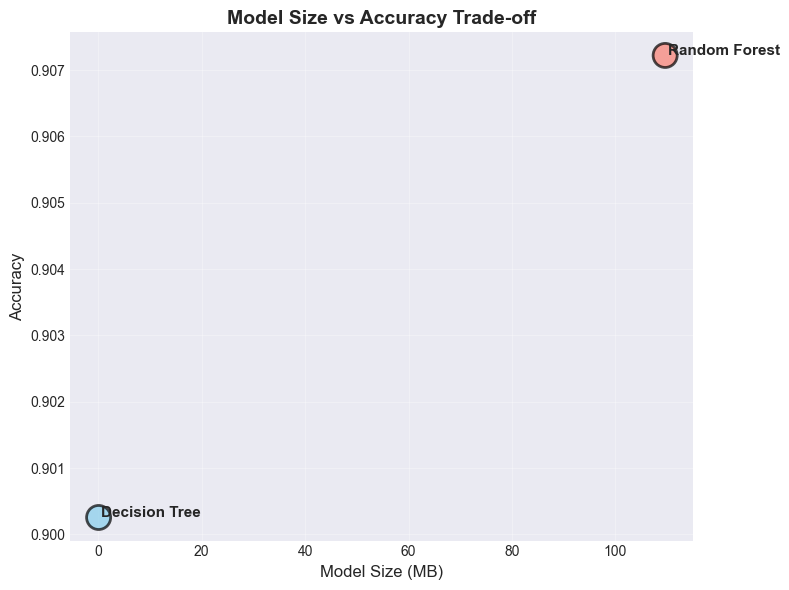

In [47]:
"""
Cell 17: Model Complexity and Efficiency Analysis
Purpose: Compare model size, inference time, and resource requirements
"""

print("="*80)
print("MODEL COMPLEXITY AND EFFICIENCY ANALYSIS")
print("="*80)

def model_size_in_mb(model, filename="temp_model.joblib"):
    """Calculate model file size in MB"""
    dump(model, filename)
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    os.remove(filename)
    return size_mb

complexity_data = []

for name, model in models.items():
    # Count nodes and depth
    if name == "Decision Tree":
        n_nodes = model.tree_.node_count
        max_depth = model.tree_.max_depth
    elif name == "Random Forest":
        n_nodes = sum(est.tree_.node_count for est in model.estimators_)
        max_depth = np.mean([est.tree_.max_depth for est in model.estimators_])

    # Measure inference time
    start = time.time()
    _ = model.predict(X_test_enc)
    infer_time = time.time() - start

    # Measure model size
    size_mb = model_size_in_mb(model)

    complexity_data.append({
        "Model": name,
        "Nodes": n_nodes,
        "Avg Depth": round(max_depth, 2),
        "Model Size (MB)": round(size_mb, 3),
        "Inference Time (s)": round(infer_time, 4)
    })

    print(f"\n{name}:")
    print(f"  Total Nodes:       {n_nodes:,}")
    print(f"  Average Depth:     {max_depth:.2f}")
    print(f"  Model Size:        {size_mb:.3f} MB")
    print(f"  Inference Time:    {infer_time:.4f} seconds")

complexity_df = pd.DataFrame(complexity_data)

print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
display(complexity_df)

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
accuracy_dict = {row['Model']: df_results_with[df_results_with['Model']==row['Model']]['Accuracy'].values[0]
                 for row in complexity_data}

scatter = ax.scatter(complexity_df["Model Size (MB)"],
                    [accuracy_dict[m] for m in complexity_df["Model"]],
                    s=300, c=['skyblue', 'salmon'],
                    edgecolors='black', linewidth=2, alpha=0.7)

for i, row in complexity_df.iterrows():
    ax.annotate(row["Model"],
                (row["Model Size (MB)"] + 0.5, accuracy_dict[row["Model"]]),
                fontsize=11, fontweight='bold')

ax.set_xlabel("Model Size (MB)", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Model Size vs Accuracy Trade-off", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Cell 18: Hyperparameter Sensitivity Analysis


HYPERPARAMETER SENSITIVITY ANALYSIS

--- Decision Tree: max_depth Sensitivity ---
  max_depth=5     : F1=0.4501
  max_depth=10    : F1=0.5075
  max_depth=15    : F1=0.5060
  max_depth=20    : F1=0.4911
  max_depth=25    : F1=0.4779
  max_depth=30    : F1=0.4640
  max_depth=None  : F1=0.4680

--- Random Forest: n_estimators Sensitivity ---
  n_estimators= 10: F1=0.4711
  n_estimators= 50: F1=0.4828
  n_estimators=100: F1=0.4907
  n_estimators=150: F1=0.4955
  n_estimators=200: F1=0.5033
  n_estimators=250: F1=0.4994
  n_estimators=300: F1=0.4979


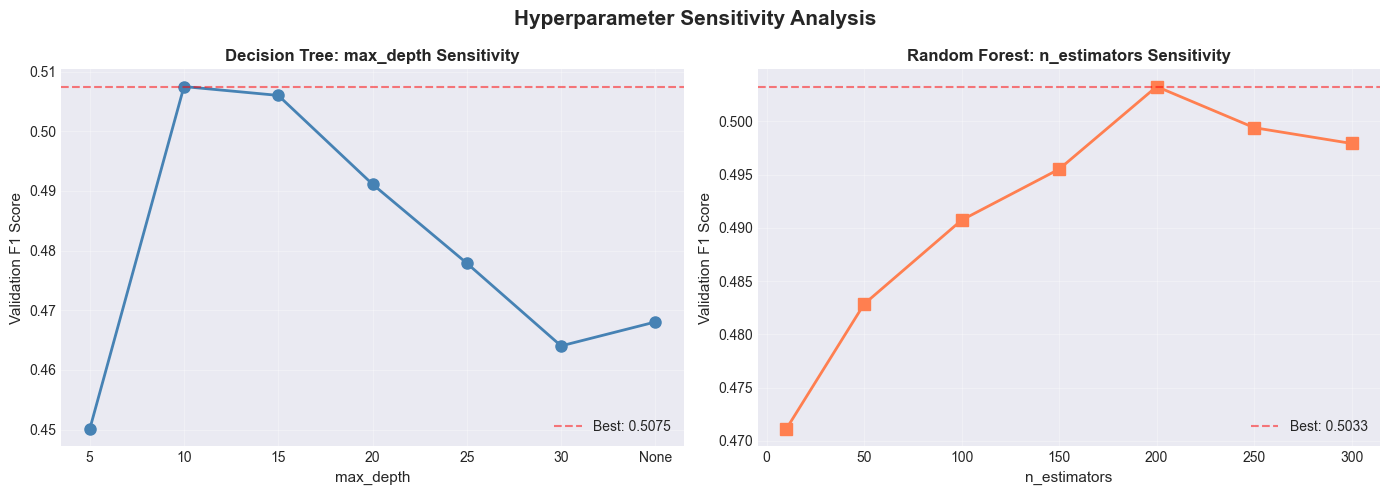


--- Performance Variability ---
Decision Tree: 11.3% variation across parameters
Random Forest: 6.4% variation across parameters

 RF is 1.8x more stable than DT


In [48]:
"""
Cell 18: Hyperparameter Sensitivity Analysis
Purpose: Visualize how performance varies with hyperparameter changes
"""

print("="*80)
print("HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*80)

# Decision Tree: max_depth sensitivity
print("\n--- Decision Tree: max_depth Sensitivity ---")
dt_depths = [5, 10, 15, 20, 25, 30, None]
dt_f1_scores = []

for d in dt_depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train_enc, y_train)
    pred = model.predict(X_val_enc)
    f1 = f1_score(y_val, pred)
    dt_f1_scores.append(f1)
    print(f"  max_depth={str(d):6s}: F1={f1:.4f}")

# Random Forest: n_estimators sensitivity
print("\n--- Random Forest: n_estimators Sensitivity ---")
rf_n_estimators = [10, 50, 100, 150, 200, 250, 300]
rf_f1_scores = []

for n in rf_n_estimators:
    model = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    model.fit(X_train_enc, y_train)
    pred = model.predict(X_val_enc)
    f1 = f1_score(y_val, pred)
    rf_f1_scores.append(f1)
    print(f"  n_estimators={n:3d}: F1={f1:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Hyperparameter Sensitivity Analysis", fontsize=15, fontweight='bold')

# Left: Decision Tree
axes[0].plot([str(d) for d in dt_depths], dt_f1_scores,
             marker='o', markersize=8, linewidth=2, color="steelblue")
axes[0].axhline(y=max(dt_f1_scores), color='red', linestyle='--',
                alpha=0.5, label=f'Best: {max(dt_f1_scores):.4f}')
axes[0].set_xlabel("max_depth", fontsize=11)
axes[0].set_ylabel("Validation F1 Score", fontsize=11)
axes[0].set_title("Decision Tree: max_depth Sensitivity", fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Right: Random Forest
axes[1].plot(rf_n_estimators, rf_f1_scores,
             marker='s', markersize=8, linewidth=2, color='coral')
axes[1].axhline(y=max(rf_f1_scores), color='red', linestyle='--',
                alpha=0.5, label=f'Best: {max(rf_f1_scores):.4f}')
axes[1].set_xlabel("n_estimators", fontsize=11)
axes[1].set_ylabel("Validation F1 Score", fontsize=11)
axes[1].set_title("Random Forest: n_estimators Sensitivity", fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Calculate variability
dt_variability = (max(dt_f1_scores) - min(dt_f1_scores)) / max(dt_f1_scores) * 100
rf_variability = (max(rf_f1_scores) - min(rf_f1_scores)) / max(rf_f1_scores) * 100

print(f"\n--- Performance Variability ---")
print(f"Decision Tree: {dt_variability:.1f}% variation across parameters")
print(f"Random Forest: {rf_variability:.1f}% variation across parameters")
print(f"\n RF is {dt_variability/rf_variability:.1f}x more stable than DT")

Cell 19: ROC and Precision-Recall Curves


ROC AND PRECISION-RECALL ANALYSIS

ROC AUC Scores:
  Decision Tree: 0.8515
  Random Forest: 0.9291
  Improvement:   +9.12%

Average Precision Scores:
  Decision Tree: 0.5008
  Random Forest: 0.6221
  Improvement:   +24.21%


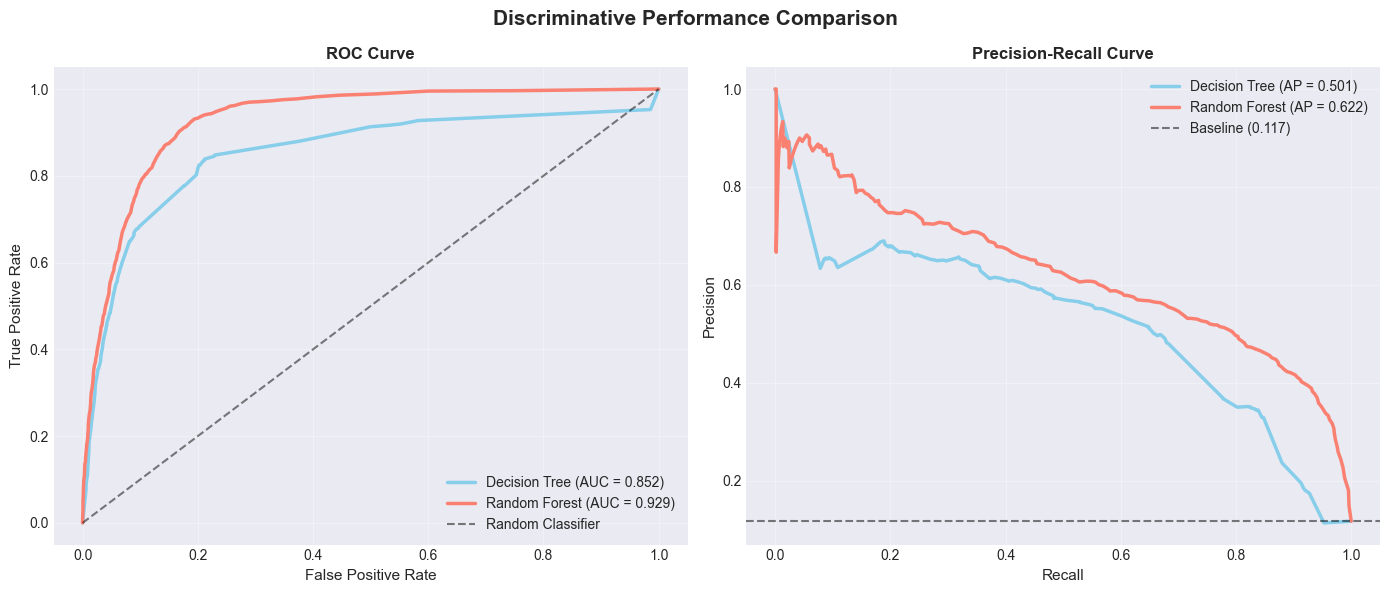

In [49]:
"""
Cell 19: ROC and Precision-Recall Curves
Purpose: Evaluate discriminative performance and precision-recall trade-offs
"""

print("="*80)
print("ROC AND PRECISION-RECALL ANALYSIS")
print("="*80)

# Get prediction probabilities
y_prob_dt = best_dt.predict_proba(X_test_enc)[:, 1]
y_prob_rf = best_rf.predict_proba(X_test_enc)[:, 1]

# --- ROC Curve ---
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)

print(f"\nROC AUC Scores:")
print(f"  Decision Tree: {auc_dt:.4f}")
print(f"  Random Forest: {auc_rf:.4f}")
print(f"  Improvement:   {(auc_rf - auc_dt)/auc_dt * 100:+.2f}%")

# --- Precision-Recall Curve ---
prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_prob_dt)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)
ap_dt = average_precision_score(y_test, y_prob_dt)
ap_rf = average_precision_score(y_test, y_prob_rf)

print(f"\nAverage Precision Scores:")
print(f"  Decision Tree: {ap_dt:.4f}")
print(f"  Random Forest: {ap_rf:.4f}")
print(f"  Improvement:   {(ap_rf - ap_dt)/ap_dt * 100:+.2f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Discriminative Performance Comparison", fontsize=15, fontweight='bold')

# Left: ROC Curve
axes[0].plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.3f})",
             lw=2.5, color='skyblue')
axes[0].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})",
             lw=2.5, color='salmon')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random Classifier')
axes[0].set_xlabel("False Positive Rate", fontsize=11)
axes[0].set_ylabel("True Positive Rate", fontsize=11)
axes[0].set_title("ROC Curve", fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Precision-Recall Curve
axes[1].plot(rec_dt, prec_dt, label=f"Decision Tree (AP = {ap_dt:.3f})",
             lw=2.5, color='skyblue')
axes[1].plot(rec_rf, prec_rf, label=f"Random Forest (AP = {ap_rf:.3f})",
             lw=2.5, color='salmon')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', lw=1.5,
                alpha=0.5, label=f'Baseline ({y_test.mean():.3f})')
axes[1].set_xlabel("Recall", fontsize=11)
axes[1].set_ylabel("Precision", fontsize=11)
axes[1].set_title("Precision-Recall Curve", fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Cell 20: Model Calibration Analysis


MODEL CALIBRATION ANALYSIS

Brier Scores (lower is better):
  Decision Tree: 0.0753
  Random Forest: 0.0632
  Improvement:   16.05%

Calibration Quality:
   Random Forest provides more reliable probability estimates


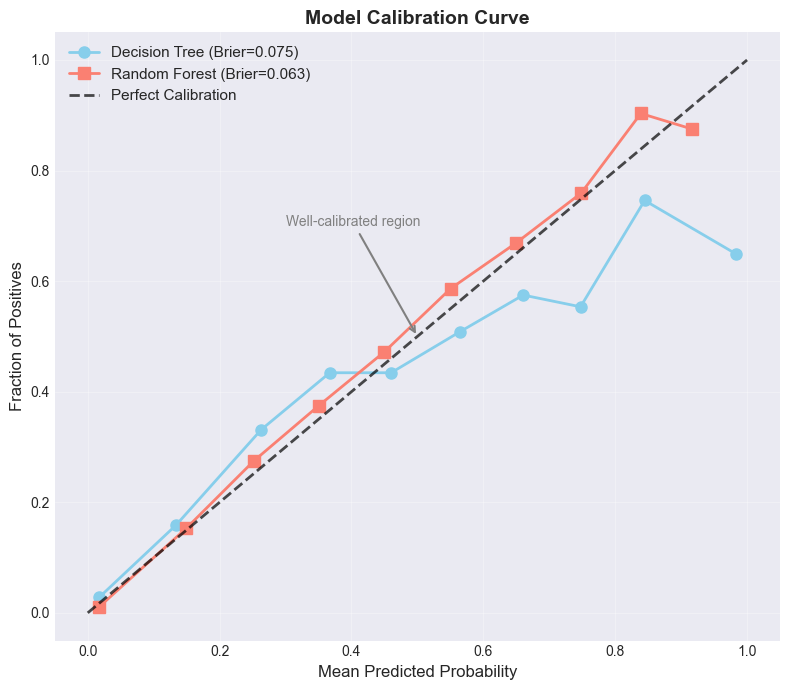


 Calibration analysis completed!


In [50]:
"""
Cell 20: Model Calibration Analysis
Purpose: Evaluate reliability of predicted probabilities
"""

print("="*80)
print("MODEL CALIBRATION ANALYSIS")
print("="*80)

# Get prediction probabilities
y_prob_dt = best_dt.predict_proba(X_test_enc)[:, 1]
y_prob_rf = best_rf.predict_proba(X_test_enc)[:, 1]

# Calculate calibration curves
prob_true_dt, prob_pred_dt = calibration_curve(y_test, y_prob_dt, n_bins=10, strategy='uniform')
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_prob_rf, n_bins=10, strategy='uniform')

# Calculate Brier scores
brier_dt = brier_score_loss(y_test, y_prob_dt)
brier_rf = brier_score_loss(y_test, y_prob_rf)

print(f"\nBrier Scores (lower is better):")
print(f"  Decision Tree: {brier_dt:.4f}")
print(f"  Random Forest: {brier_rf:.4f}")
print(f"  Improvement:   {(brier_dt - brier_rf)/brier_dt * 100:.2f}%")

print(f"\nCalibration Quality:")
if brier_rf < brier_dt:
    print(f"   Random Forest provides more reliable probability estimates")
else:
    print(f"   Decision Tree provides more reliable probability estimates")

# Visualization
fig, ax = plt.subplots(figsize=(8, 7))

ax.plot(prob_pred_dt, prob_true_dt, marker='o', markersize=8, linewidth=2,
        label=f"Decision Tree (Brier={brier_dt:.3f})", color='skyblue')
ax.plot(prob_pred_rf, prob_true_rf, marker='s', markersize=8, linewidth=2,
        label=f"Random Forest (Brier={brier_rf:.3f})", color='salmon')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label="Perfect Calibration", alpha=0.7)

ax.set_xlabel("Mean Predicted Probability", fontsize=12)
ax.set_ylabel("Fraction of Positives", fontsize=12)
ax.set_title("Model Calibration Curve", fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('Well-calibrated region', xy=(0.5, 0.5), xytext=(0.3, 0.7),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
            fontsize=10, color='gray')

plt.tight_layout()
plt.show()

print("\n Calibration analysis completed!")

Cell 21: Detailed Hyperparameter Comparison (Model Size, Time, Accuracy)


In [51]:
"""
Cell 21: Detailed Hyperparameter Comparison (Model Size, Time, Accuracy)
Purpose: Comprehensive analysis of efficiency-accuracy trade-offs
"""

print("="*80)
print("DETAILED HYPERPARAMETER COMPARISON")
print("="*80)

def measure_model_metrics(model, X_train, y_train, X_test, y_test):
    """Measure model size, accuracy, and timing"""
    # Training
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    # Inference
    start_test = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_test

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    size_mb = model_size_in_mb(model)

    return {
        'accuracy': acc,
        'model_size_mb': size_mb,
        'train_time': train_time,
        'inference_time': test_time
    }

# --- Decision Tree Analysis ---
print("\n--- Decision Tree: max_depth Comparison ---")
dt_results = []
dt_max_depths = [5, 10, 15, 20, 25, 30, None]

for depth in dt_max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    metrics = measure_model_metrics(dt, X_train_enc, y_train, X_test_enc, y_test)

    dt_results.append({
        'max_depth': str(depth) if depth is not None else 'None',
        'accuracy': metrics['accuracy'],
        'model_size_mb': metrics['model_size_mb'],
        'train_time': metrics['train_time'],
        'inference_time': metrics['inference_time']
    })

    print(f"  max_depth={str(depth):6s}: Acc={metrics['accuracy']:.4f}, "
          f"Size={metrics['model_size_mb']:.3f}MB, "
          f"Train={metrics['train_time']:.3f}s, "
          f"Infer={metrics['inference_time']:.4f}s")

df_dt_comparison = pd.DataFrame(dt_results)

# --- Random Forest Analysis ---
print("\n--- Random Forest: n_estimators Comparison ---")
rf_results = []
rf_n_estimators = [10, 50, 100, 150, 200, 250, 300]

for n_est in rf_n_estimators:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42, n_jobs=-1)
    metrics = measure_model_metrics(rf, X_train_enc, y_train, X_test_enc, y_test)

    rf_results.append({
        'n_estimators': n_est,
        'accuracy': metrics['accuracy'],
        'model_size_mb': metrics['model_size_mb'],
        'train_time': metrics['train_time'],
        'inference_time': metrics['inference_time']
    })

    print(f"  n_estimators={n_est:3d}: Acc={metrics['accuracy']:.4f}, "
          f"Size={metrics['model_size_mb']:.2f}MB, "
          f"Train={metrics['train_time']:.2f}s, "
          f"Infer={metrics['inference_time']:.4f}s")

df_rf_comparison = pd.DataFrame(rf_results)

# Display summaries
print("\n" + "="*80)
print("DECISION TREE SUMMARY")
print("="*80)
display(df_dt_comparison.round(4))

print("\n" + "="*80)
print("RANDOM FOREST SUMMARY")
print("="*80)
display(df_rf_comparison.round(4))


DETAILED HYPERPARAMETER COMPARISON

--- Decision Tree: max_depth Comparison ---
  max_depth=5     : Acc=0.8988, Size=0.006MB, Train=0.090s, Infer=0.0013s
  max_depth=10    : Acc=0.8993, Size=0.060MB, Train=0.155s, Infer=0.0014s
  max_depth=15    : Acc=0.8902, Size=0.165MB, Train=0.215s, Infer=0.0021s
  max_depth=20    : Acc=0.8806, Size=0.259MB, Train=0.261s, Infer=0.0022s
  max_depth=25    : Acc=0.8756, Size=0.322MB, Train=0.289s, Infer=0.0021s
  max_depth=30    : Acc=0.8729, Size=0.340MB, Train=0.285s, Infer=0.0020s
  max_depth=None  : Acc=0.8731, Size=0.339MB, Train=0.274s, Infer=0.0019s

--- Random Forest: n_estimators Comparison ---
  n_estimators= 10: Acc=0.9030, Size=4.19MB, Train=0.12s, Infer=0.1068s
  n_estimators= 50: Acc=0.9059, Size=21.17MB, Train=0.41s, Infer=0.0305s
  n_estimators=100: Acc=0.9069, Size=42.32MB, Train=0.76s, Infer=0.0512s
  n_estimators=150: Acc=0.9072, Size=63.43MB, Train=1.15s, Infer=0.0765s
  n_estimators=200: Acc=0.9066, Size=84.42MB, Train=1.51s, Infe

,max_depth,accuracy,model_size_mb,train_time,inference_time
0,5,0.8988,0.0061,0.0904,0.0013
1,10,0.8993,0.0599,0.1549,0.0014
2,15,0.8902,0.1651,0.2150,0.0021
3,20,0.8806,0.2591,0.2612,0.0022
4,25,0.8756,0.3216,0.2894,0.0021
5,30,0.8729,0.3404,0.2846,0.0020
6,None,0.8731,0.3390,0.2742,0.0019



RANDOM FOREST SUMMARY


,n_estimators,accuracy,model_size_mb,train_time,inference_time
0,10,0.9030,4.1855,0.1243,0.1068
1,50,0.9059,21.1698,0.4117,0.0305
2,100,0.9069,42.3235,0.7631,0.0512
3,150,0.9072,63.4322,1.1472,0.0765
4,200,0.9066,84.4245,1.5050,0.0976
5,250,0.9066,105.6652,2.0082,0.1235
6,300,0.9071,126.5915,2.3904,0.1427


Cell 22: Efficiency-Accuracy Trade-off Visualization


VISUALIZING EFFICIENCY-ACCURACY TRADE-OFFS


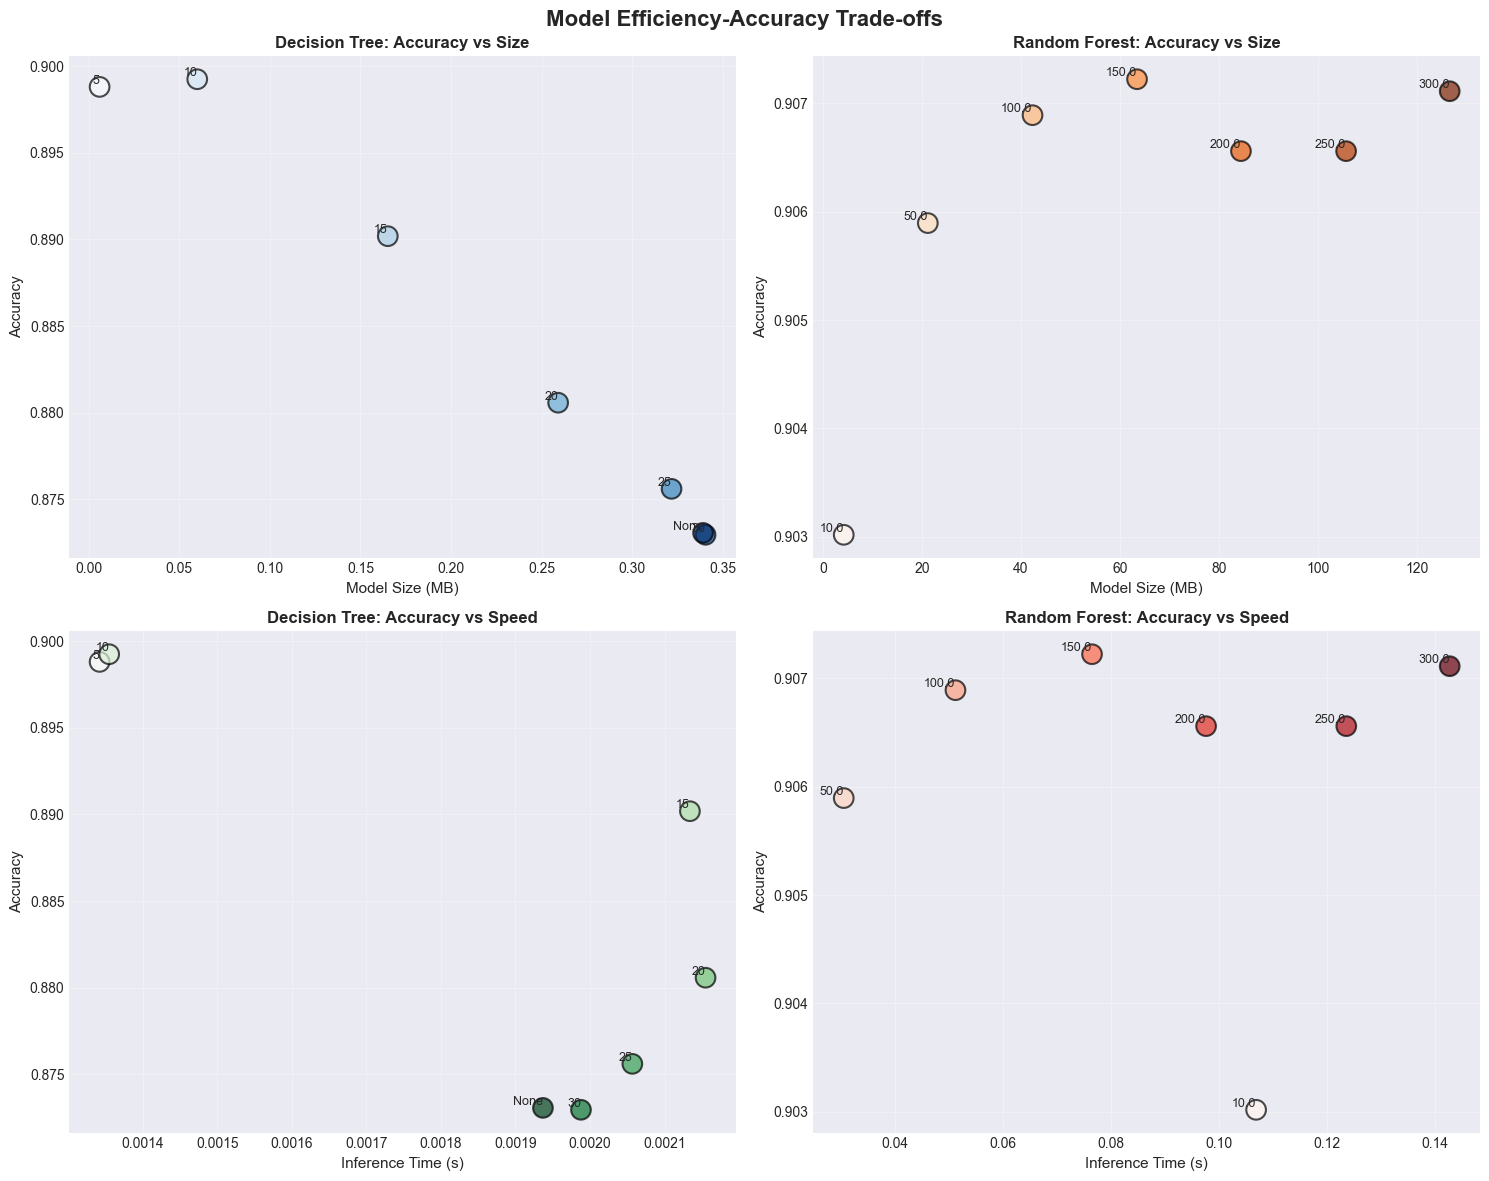


--- Optimal Configurations ---
Decision Tree (max_depth=10):
  Accuracy: 0.8993
  Size:     0.060 MB
  Speed:    0.0014 s

Random Forest (n_estimators=150.0):
  Accuracy: 0.9072
  Size:     63.43 MB
  Speed:    0.0765 s

--- RF vs DT Trade-offs ---
  Accuracy gain: +0.80%
  Size cost:     1058.4x larger
  Speed cost:    56.4x slower


In [ ]:
"""
Cell 22: Efficiency-Accuracy Trade-off Visualization
Purpose: Comprehensive visual comparison of model trade-offs
"""

print("="*80)
print("VISUALIZING EFFICIENCY-ACCURACY TRADE-OFFS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Efficiency-Accuracy Trade-offs', fontsize=16, fontweight='bold')

# --- Plot 1: Accuracy vs Model Size (DT) ---
axes[0, 0].scatter(df_dt_comparison['model_size_mb'], df_dt_comparison['accuracy'],
                   s=200, c=range(len(df_dt_comparison)), cmap='Blues',
                   edgecolors='black', linewidth=1.5, alpha=0.7)
for i, row in df_dt_comparison.iterrows():
    axes[0, 0].annotate(row['max_depth'],
                        (row['model_size_mb'], row['accuracy']),
                        fontsize=9, ha='right', va='bottom')
axes[0, 0].set_xlabel('Model Size (MB)', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Decision Tree: Accuracy vs Size', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# --- Plot 2: Accuracy vs Model Size (RF) ---
axes[0, 1].scatter(df_rf_comparison['model_size_mb'], df_rf_comparison['accuracy'],
                   s=200, c=range(len(df_rf_comparison)), cmap='Oranges',
                   edgecolors='black', linewidth=1.5, alpha=0.7)
for i, row in df_rf_comparison.iterrows():
    axes[0, 1].annotate(f"{row['n_estimators']}",
                        (row['model_size_mb'], row['accuracy']),
                        fontsize=9, ha='right', va='bottom')
axes[0, 1].set_xlabel('Model Size (MB)', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Random Forest: Accuracy vs Size', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# --- Plot 3: Accuracy vs Inference Time (DT) ---
axes[1, 0].scatter(df_dt_comparison['inference_time'], df_dt_comparison['accuracy'],
                   s=200, c=range(len(df_dt_comparison)), cmap='Greens',
                   edgecolors='black', linewidth=1.5, alpha=0.7)
for i, row in df_dt_comparison.iterrows():
    axes[1, 0].annotate(row['max_depth'],
                        (row['inference_time'], row['accuracy']),
                        fontsize=9, ha='right', va='bottom')
axes[1, 0].set_xlabel('Inference Time (s)', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].set_title('Decision Tree: Accuracy vs Speed', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# --- Plot 4: Accuracy vs Inference Time (RF) ---
axes[1, 1].scatter(df_rf_comparison['inference_time'], df_rf_comparison['accuracy'],
                   s=200, c=range(len(df_rf_comparison)), cmap='Reds',
                   edgecolors='black', linewidth=1.5, alpha=0.7)
for i, row in df_rf_comparison.iterrows():
    axes[1, 1].annotate(f"{row['n_estimators']}",
                        (row['inference_time'], row['accuracy']),
                        fontsize=9, ha='right', va='bottom')
axes[1, 1].set_xlabel('Inference Time (s)', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Random Forest: Accuracy vs Speed', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate trade-off ratios
optimal_dt = df_dt_comparison.iloc[df_dt_comparison['accuracy'].idxmax()]
optimal_rf = df_rf_comparison.iloc[df_rf_comparison['accuracy'].idxmax()]

print(f"\n--- Optimal Configurations ---")
print(f"Decision Tree (max_depth={optimal_dt['max_depth']}):")
print(f"  Accuracy: {optimal_dt['accuracy']:.4f}")
print(f"  Size:     {optimal_dt['model_size_mb']:.3f} MB")
print(f"  Speed:    {optimal_dt['inference_time']:.4f} s")

print(f"\nRandom Forest (n_estimators={optimal_rf['n_estimators']}):")
print(f"  Accuracy: {optimal_rf['accuracy']:.4f}")
print(f"  Size:     {optimal_rf['model_size_mb']:.2f} MB")
print(f"  Speed:    {optimal_rf['inference_time']:.4f} s")

print(f"\n--- RF vs DT Trade-offs ---")
print(f"  Accuracy gain: +{(optimal_rf['accuracy']-optimal_dt['accuracy'])*100:.2f}%")
print(f"  Size cost:     {optimal_rf['model_size_mb']/optimal_dt['model_size_mb']:.1f}x larger")
print(f"  Speed cost:    {optimal_rf['inference_time']/optimal_dt['inference_time']:.1f}x slower")

Cell 23: Training Time Comparison


TRAINING TIME ANALYSIS


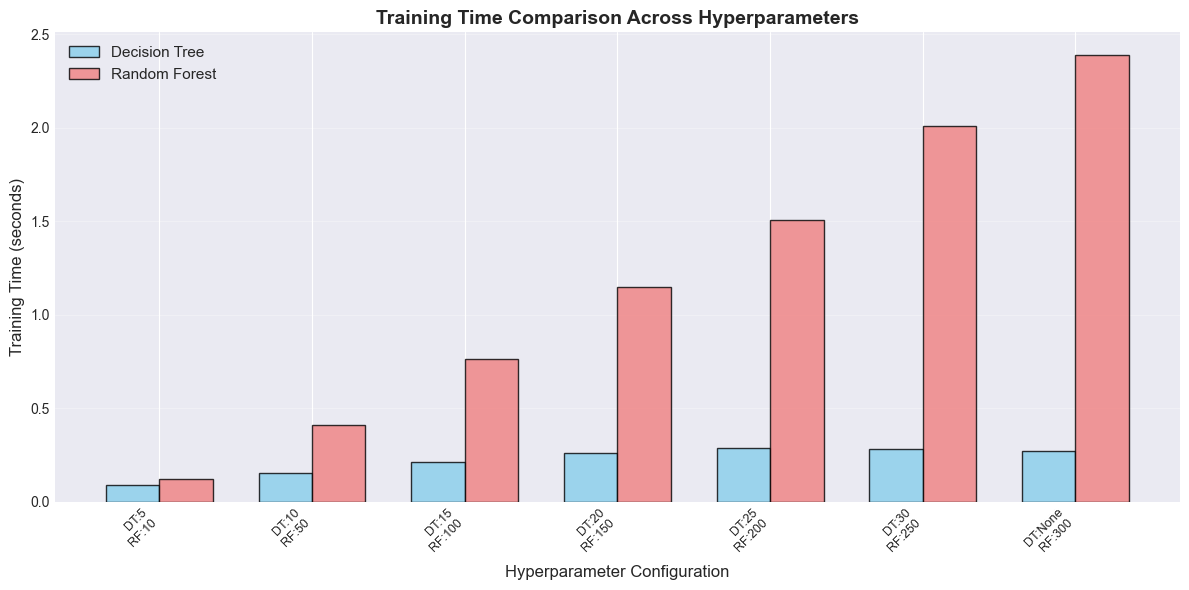


Training Time Statistics:
Decision Tree:
  Mean:   0.224s
  Median: 0.261s
  Range:  0.090s - 0.289s

Random Forest:
  Mean:   1.19s
  Median: 1.15s
  Range:  0.12s - 2.39s

RF is 5.3x slower to train


In [53]:
"""
Cell 23: Training Time Comparison
Purpose: Compare computational cost during training phase
"""

print("="*80)
print("TRAINING TIME ANALYSIS")
print("="*80)

# Prepare data for visualization
fig, ax = plt.subplots(figsize=(12, 6))

x_positions = np.arange(max(len(df_dt_comparison), len(df_rf_comparison)))
width = 0.35

# Decision Tree bars
bars1 = ax.bar(x_positions[:len(df_dt_comparison)] - width/2,
               df_dt_comparison['train_time'],
               width, label='Decision Tree',
               color='skyblue', edgecolor='black', alpha=0.8)

# Random Forest bars
bars2 = ax.bar(x_positions[:len(df_rf_comparison)] + width/2,
               df_rf_comparison['train_time'],
               width, label='Random Forest',
               color='lightcoral', edgecolor='black', alpha=0.8)

ax.set_xlabel('Hyperparameter Configuration', fontsize=12)
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('Training Time Comparison Across Hyperparameters',
             fontsize=14, fontweight='bold')

# Create labels
labels = [f"DT:{d}\nRF:{n}" for d, n in
          zip(df_dt_comparison['max_depth'],
              df_rf_comparison['n_estimators'])]
ax.set_xticks(x_positions[:len(labels)])
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)

ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\nTraining Time Statistics:")
print(f"Decision Tree:")
print(f"  Mean:   {df_dt_comparison['train_time'].mean():.3f}s")
print(f"  Median: {df_dt_comparison['train_time'].median():.3f}s")
print(f"  Range:  {df_dt_comparison['train_time'].min():.3f}s - {df_dt_comparison['train_time'].max():.3f}s")

print(f"\nRandom Forest:")
print(f"  Mean:   {df_rf_comparison['train_time'].mean():.2f}s")
print(f"  Median: {df_rf_comparison['train_time'].median():.2f}s")
print(f"  Range:  {df_rf_comparison['train_time'].min():.2f}s - {df_rf_comparison['train_time'].max():.2f}s")

print(f"\nRF is {df_rf_comparison['train_time'].mean()/df_dt_comparison['train_time'].mean():.1f}x slower to train")